# Bike Sharing Assignment
## Assignment is divided into following parts:
- Data Exploration
- Exploratory Data Analysis (EDA)
- Encoding Dummy Variables
- Partitioning the Data into Training and Testing Sets
- Constructing our Model using sklearn RFE and the Statsmodel API
- Analyzing Residuals in the Training Data
- Identifying Patterns in the Residuals
- Generating Predictions on the Test Set
- Evaluating Model Performance
- Concluding Analysis

# Submitted by:
# Rohit Chandel

## Importing Libraries

In [11]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
# to display all coulmns of a dataframe
pd.set_option('display.max_column', None)

# to display all rows of a dataframe
pd.set_option('display.max_rows', None)

# to display all items of a long sequence
pd.set_option('display.max_seq_items', None)

# to display complete contents inside a cell in dataframe
pd.set_option('display.max_colwidth', None)

pd.set_option('expand_frame_repr', True)

## Reading and Understanding the Data

In [15]:
bike_df = pd.read_csv("datasets/day.csv")

In [16]:
# Check the head of the dataset
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## data contains 730 rows and 16 columns

In [5]:
bike_df.shape

(730, 16)

## We can exclude these columns for model development purposes. Let's remove them.

In [6]:
drop_these_columns = ["instant",
                      "dteday"]
bike_df.drop(drop_these_columns, inplace=True, axis=1)
bike_df.shape

(730, 14)

## Visualising the Data

Now, let's dedicate some time to a crucial step — **grasping the data**.
- Detecting apparent multicollinearity is particularly critical at this stage.
- This is also the juncture where we can pinpoint predictors that might exhibit a pronounced association with the outcome variable.

We'll employ `matplotlib` and `seaborn` to visualize our data.

#### Visualising Numeric Variables

Let's make a pairplot of all the numeric variables

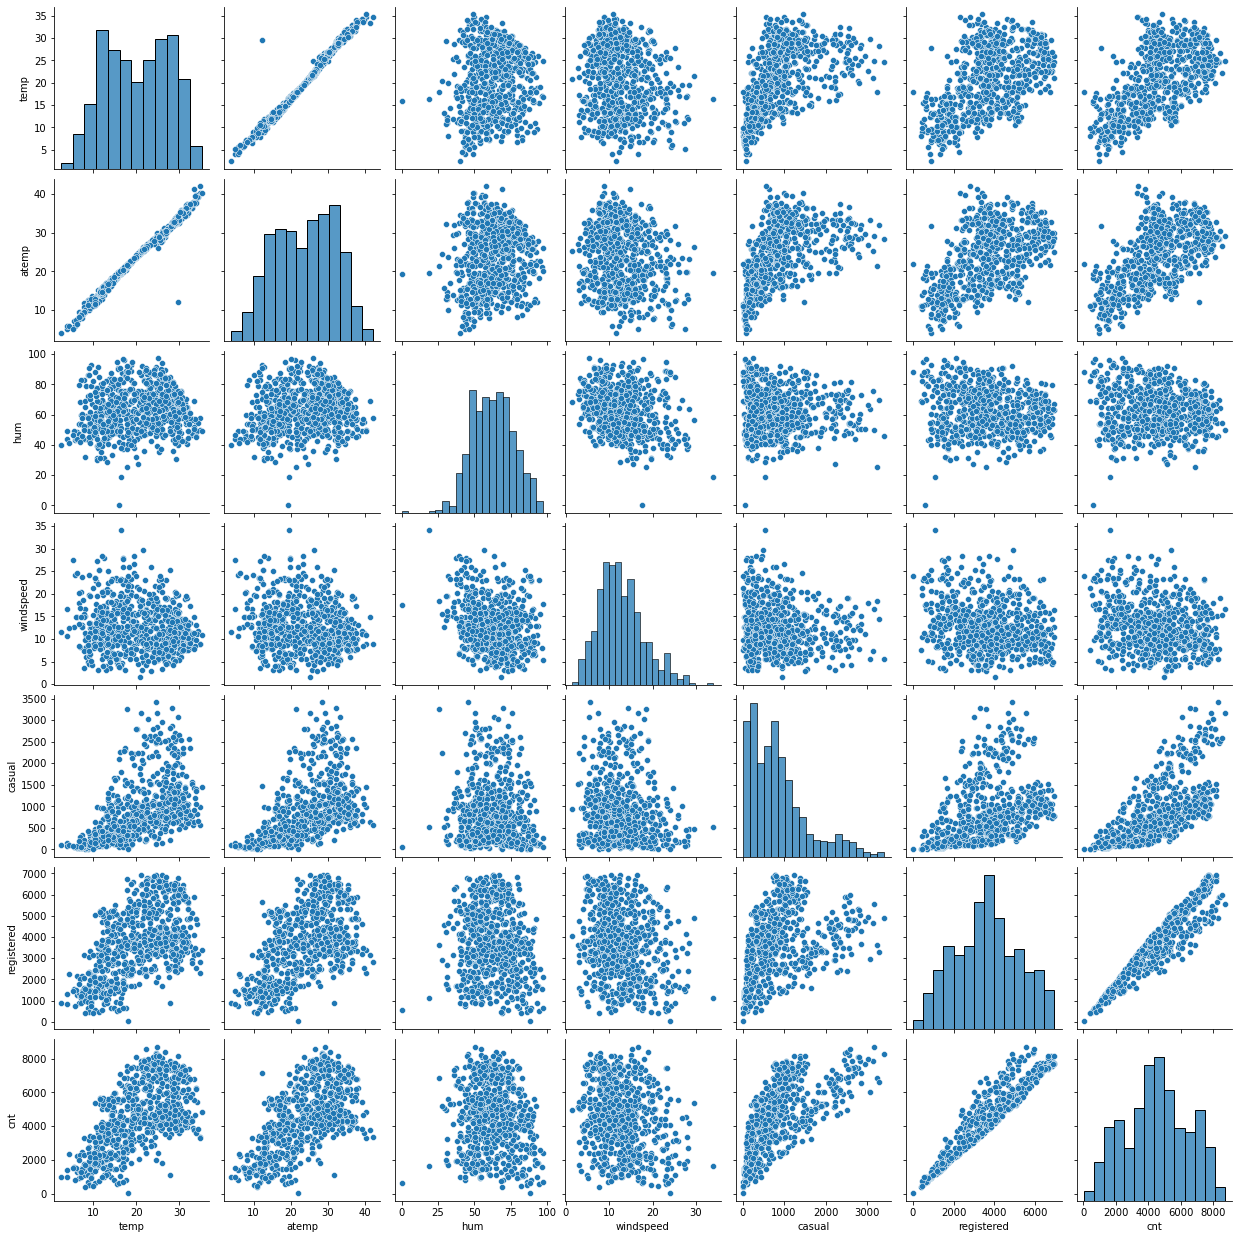

In [7]:
sns.pairplot(bike_df[["temp","atemp","hum","windspeed","casual","registered","cnt"]])
plt.show()

## Key Insights from the Pairplot Analysis:
#### 1. There is a strong correlation between `temp` and `atemp`.
#### 2. `temp` exhibits correlation with `casual`, `registered`, and `cnt`.
#### 3. Similarly, `atemp` shows correlation with `casual`, `registered`, and `cnt`.
#### 4. Notably, `casual` is correlated with `registered` and `cnt`, which is expected since `casual + registered = cnt`.

#### It is imperative to address these correlations among potential predictor variables to mitigate multicollinearity when constructing our Multiple Linear Regression Model.

#### Additionally, we will exclude `casual` and `registered` from our preprocessed data during model training to prevent potential information leakage and overfitting.

## Let's examine the correlation coefficients to identify highly correlated variables.

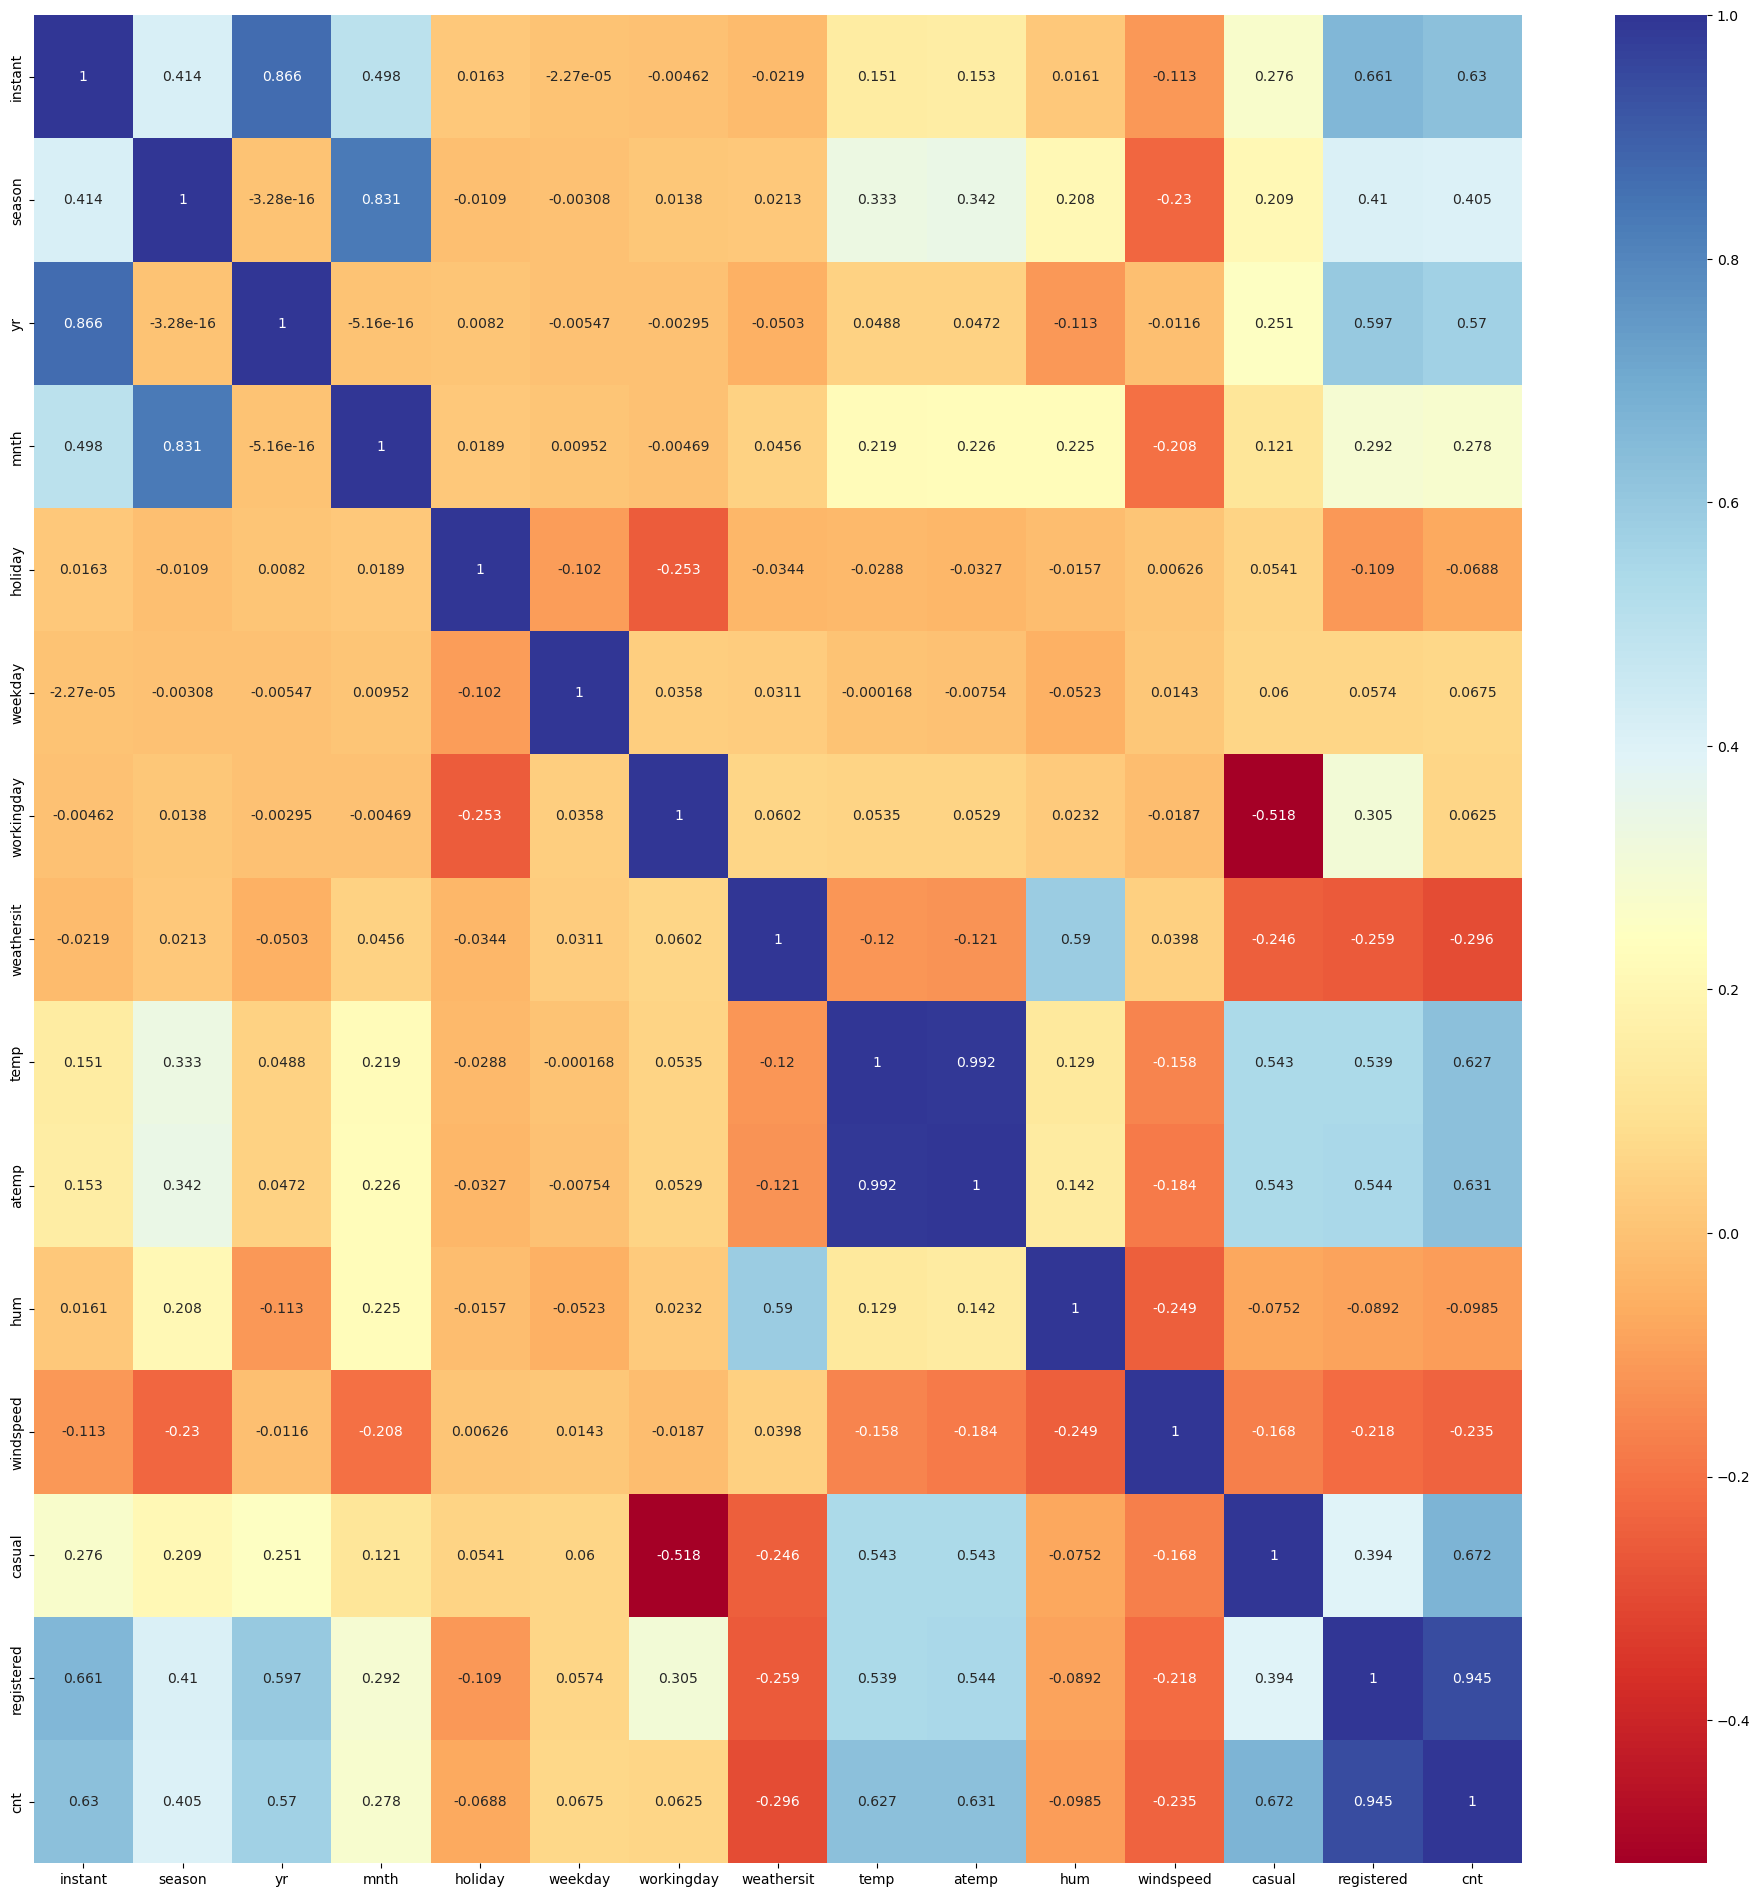

In [19]:
plt.figure(figsize = (24, 24))
sns.heatmap(bike_df.corr(), annot = True, fmt='0.3g', cmap="RdYlBu")
plt.show()

## Key Insights from the Heat Map Analysis:
### 1) Excluding casual and registered (which we'll drop), `atemp` demonstrates the highest correlation coefficient with `cnt`, followed by `temp`.
### 2) `season` shows a decent correlation with `cnt`, falling in a moderate range.
### 3) `yr` also exhibits a correlation with `cnt`, suggesting it could be a contributing factor.
### 4) The correlation coefficient for `mnth` is relatively low. A statistical check is warranted; only certain months might be statistically significant for the model.
### 5) `holiday` is negatively correlated with `cnt`.
### 6) Statistical significance checks are needed for `weekday`, `workingday`, `weathersit`, `hum`, and `windspeed`.

These insights will guide further steps in feature selection and model building.

## Visualizing Categorical Variables

### Notably, there are several categorical variables in our dataset. To gain insights, let's create boxplots for some of these variables.

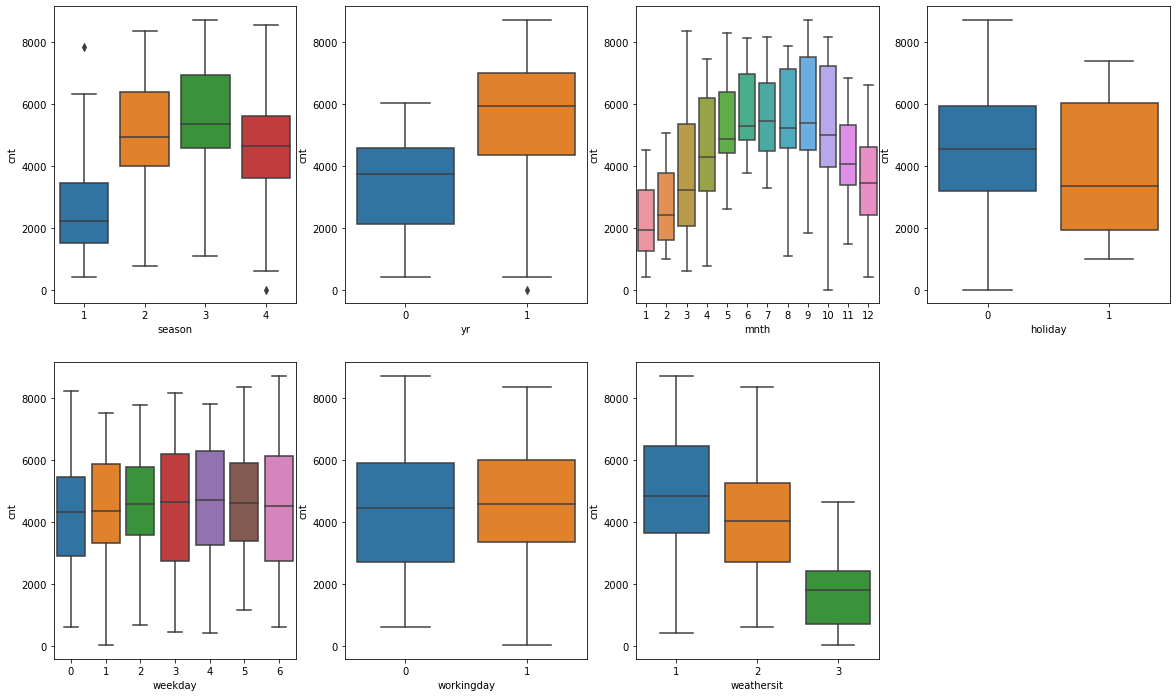

In [9]:
plt.figure(figsize=(20, 12))
plt.subplot(2,4,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike_df)
plt.subplot(2,4,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bike_df)
plt.subplot(2,4,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike_df)
plt.subplot(2,4,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike_df)
plt.subplot(2,4,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike_df)
plt.subplot(2,4,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike_df)
plt.subplot(2,4,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike_df)
plt.show()

## Key Insights from the Boxplots:
### 1. The median of bike rental count is highest during the fall season. A statistical check is required for confirmation.
### 2. The maximum bike rental count also occurs during the fall season.
### 3. The median of bike rental count is highest in the year 2019, and the maximum bike rental count is also recorded in that year.
### 4. September (month 9) has the highest bike rental count.
### 5. July (month 7) has the highest median bike rental count.
### 6. October (month 10) has the lowest bike rental count.
### 7. The median and highest bike rental counts are observed on days without a marked holiday (holiday = 0).
### 8. Bike rental medians are comparable across all days.
### 9. Bike rental medians are similar for working and non-working days.
### 10. The highest bike rental median is associated with weather situation 1. Moreover, the maximum bike rental count is observed for weather situation 1, while the lowest is for weather situation 3.

These observations provide valuable insights into the factors influencing bike rental counts based on categorical variables. Further statistical analysis will help confirm the significance of these findings.

## Custom Map Functions

In [10]:
# Defining the season map function
def mapping_season_col(x):
    return x.map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})

# Defining the weather map function
def mapping_weathersit_col(x):
    return x.map({1:"weathersit_1", 2:"weathersit_2", 3:"weathersit_3", 4:"weathersit_4"})

# Defining the month map function
def mapping_month_col(x):
    return x.map({1:"month_1", 
                  2:"month_2", 
                  3:"month_3", 
                  4:"month_4",
                  5:"month_5",
                  6:"month_6",
                  7:"month_7",
                  8:"month_8",
                  9:"month_9",
                  10:"month_10",
                  11:"month_11",
                  12:"month_12"})

# Defining the weekday map function
def mapping_weekday_col(x):
    return x.map({0:"Monday", 
                  1:"Tuesday", 
                  2:"Wednesday", 
                  3:"Thursday",
                  4:"Friday",
                  5:"Saturday",
                  6:"Sunday"})

# Applying the function to the season column
bike_df[["season"]] = bike_df[["season"]].apply(mapping_season_col)

# Applying the function to the weathersit column
bike_df[["weathersit"]] = bike_df[["weathersit"]].apply(mapping_weathersit_col)

# Applying the function to the month column
bike_df[["mnth"]] = bike_df[["mnth"]].apply(mapping_month_col)

# Applying the function to the weekday column
bike_df[["weekday"]] = bike_df[["weekday"]].apply(mapping_weekday_col)

## Dummy Variables Encoding

In [11]:
# Get the dummy variables for the feature 'season' and store it in a new variable - 'season_dummy_var'
season_dummy_var = pd.get_dummies(bike_df["season"], drop_first = True)

In [12]:
season_dummy_var.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [13]:
# Get the dummy variables for the feature 'weathersit' and store it in a new variable - 'weathersit_dummy_var'
weathersit_dummy_var = pd.get_dummies(bike_df["weathersit"],drop_first = True)

In [14]:
weathersit_dummy_var.head()

,weathersit_2,weathersit_3
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0


In [15]:
# Get the dummy variables for the feature 'mnth' and store it in a new variable - 'mnth_dummy_var'
mnth_dummy_var = pd.get_dummies(bike_df["mnth"],drop_first = True)

In [16]:
mnth_dummy_var.head()

,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# Get the dummy variables for the feature 'weekday' and store it in a new variable - 'weekday_dummy_var'
weekday_dummy_var = pd.get_dummies(bike_df["weekday"],drop_first = True)

In [18]:
weekday_dummy_var.head()

,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,1,0,0,0
1,1,0,0,0,0,0
2,0,0,0,0,1,0
3,0,0,0,0,0,1
4,0,0,0,1,0,0


In [19]:
# Add the results to the original bike_df dataframe

bike_df = pd.concat([bike_df, season_dummy_var, weathersit_dummy_var, mnth_dummy_var, weekday_dummy_var], axis = 1)

In [20]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,spring,0,month_1,0,Sunday,0,weathersit_2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,spring,0,month_1,0,Monday,0,weathersit_2,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,spring,0,month_1,0,Tuesday,1,weathersit_1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,spring,0,month_1,0,Wednesday,1,weathersit_1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,spring,0,month_1,0,Thursday,1,weathersit_1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [21]:
drop_these_columns_2 = ["season",
                        "weathersit",
                        "mnth",
                        "weekday",
                        "casual",
                        "registered"]
bike_df.drop(drop_these_columns_2, inplace=True, axis=1)
bike_df.shape

(730, 30)

In [22]:
bike_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [23]:
bike_df.shape

(730, 30)

## Splitting the Data into Training and Testing Sets

As we know, the first basic step for regression is performing a train-test split.

In [24]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
bike_df_train, bike_df_test = train_test_split(bike_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [25]:
bike_df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
653,1,0,1,19.201653,23.0423,55.8333,12.208807,7534,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
576,1,0,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
426,1,0,0,16.980847,20.6746,62.1250,10.792293,4066,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
728,1,0,0,10.489153,11.5850,48.3333,23.500518,1796,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
482,1,0,0,15.443347,18.8752,48.9583,8.708325,4220,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [26]:
# Apply scaler() to all the columns except the '0-1' and 'dummy' variables
scaler = MinMaxScaler()

num_vars = ["temp", "atemp", "hum", "windspeed", "cnt"]

bike_df_train[num_vars] = scaler.fit_transform(bike_df_train[num_vars])

In [27]:
bike_df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [28]:
bike_df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620,0.243137,0.245098,0.24902,0.343137,0.029412,0.086275,0.086275,0.084314,0.066667,0.098039,0.078431,0.084314,0.074510,0.076471,0.096078,0.080392,0.143137,0.127451,0.154902,0.158824,0.150980,0.131373
std,0.500429,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593,0.429398,0.430568,0.43287,0.475223,0.169124,0.281045,0.281045,0.278131,0.249689,0.297660,0.269113,0.278131,0.262857,0.266010,0.294988,0.272166,0.350557,0.333805,0.362166,0.365870,0.358381,0.338139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### As we can see from above table, all values have been mapped between 0 and 1 where maximum value is 1 and minimum value is 0. This has been performed by MinMaxScaler().

### Dividing into X and Y sets for the model building

In [29]:
y_train = bike_df_train.pop('cnt')
X_train = bike_df_train ## assigning all feature variables to X_train

## Building our model

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

## RFE (Recursive Feature Elimination)

In [30]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 18) # running RFE
rfe = rfe.fit(X_train, y_train)

In [31]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 4),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 3),
 ('winter', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1),
 ('month_10', False, 2),
 ('month_11', False, 7),
 ('month_12', False, 8),
 ('month_2', False, 5),
 ('month_3', True, 1),
 ('month_4', True, 1),
 ('month_5', True, 1),
 ('month_6', True, 1),
 ('month_7', False, 9),
 ('month_8', True, 1),
 ('month_9', True, 1),
 ('Monday', True, 1),
 ('Saturday', False, 6),
 ('Sunday', True, 1),
 ('Thursday', False, 12),
 ('Tuesday', False, 10),
 ('Wednesday', False, 11)]

In [32]:
col = X_train.columns[rfe.support_] ## variables suggested by RFE
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'winter', 'weathersit_2', 'weathersit_3', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_8', 'month_9', 'Monday', 'Sunday'],
      dtype='object')

In [33]:
X_train.columns[~rfe.support_] ## rejected variables

Index(['atemp', 'summer', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_7', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

## Building model using statsmodel, for the detailed statistics
## We are assuming significance level of 0.05.

In [34]:
# Calculate the VIFs for the new model
def calculate_VIF(col,X_train):
    vif = pd.DataFrame()
    vif['Features'] = col
    vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    display(vif)

In [35]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [36]:
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)

In [37]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the 1st linear model

In [38]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     161.9
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          6.43e-189
Time:                        19:21:43   Log-Likelihood:                 519.45
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     492   BIC:                            -926.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2032      0.027      7.527   

Examining the p-values suggests that the holiday variable lacks significance amid other variables. Should we consider removing it? One approach is to drop the variable with the highest non-significant p-value, but a more comprehensive strategy would involve incorporating VIF information. 

### Verifying VIF

The Variance Inflation Factor (VIF) provides a quantitative measure of the correlation among feature variables, playing a crucial role in testing our linear model. The formula for calculating `VIF` is expressed as:

### \( VIF_i = \frac{1}{1 - {R_i}^2} \)
 





In [39]:
calculate_VIF(col,X_train)

,Features,VIF
2,workingday,48.19
17,Sunday,11.61
16,Monday,11.23
6,spring,4.11
3,temp,3.35
7,winter,3.18
1,holiday,2.81
4,hum,1.94
11,month_4,1.83
14,month_8,1.77


## We need to bring all VIFs below 5 to avoid multicollinearity issue.

## Model 2

In [40]:
X_train_new = X_train[col].drop(["holiday"], axis = 1) # dropping holiday variable

In [41]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [42]:
lm_2 = sm.OLS(y_train,X_train_lm).fit()   # Running the 2nd linear model

In [43]:
#Let's see the summary of our linear model
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     161.9
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          6.43e-189
Time:                        19:21:43   Log-Likelihood:                 519.45
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     492   BIC:                            -926.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1918      0.041      4.634   

In [44]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
3,hum,30.95
2,temp,18.34
1,workingday,18.20
4,windspeed,4.96
16,Sunday,4.85
15,Monday,4.70
5,spring,4.15
6,winter,3.58
7,weathersit_2,2.30
0,yr,2.10


## Model 3

In [45]:
X_train_new = X_train_new.drop(["hum"], axis = 1) # dropping "hum" variable

In [46]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [47]:
lm_3 = sm.OLS(y_train,X_train_lm).fit()   # Running the 3rd linear model

In [48]:
#Let's see the summary of our linear model
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     166.3
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          8.29e-187
Time:                        19:21:43   Log-Likelihood:                 511.71
No. Observations:                 510   AIC:                            -989.4
Df Residuals:                     493   BIC:                            -917.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1133      0.037      3.090   

In [49]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
1,workingday,15.27
2,temp,13.40
3,windspeed,4.87
15,Sunday,4.23
14,Monday,3.98
4,spring,3.47
5,winter,2.86
0,yr,2.09
12,month_8,1.94
9,month_4,1.74


## Model 4

In [50]:
X_train_new = X_train_new.drop(["Monday"], axis = 1) # dropping "Monday" variable because its p-value is greater than 0.05

In [51]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [52]:
lm_4 = sm.OLS(y_train,X_train_lm).fit()   # Running the 4th linear model

In [53]:
#Let's see the summary of our linear model
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     176.3
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          3.06e-187
Time:                        19:21:43   Log-Likelihood:                 510.04
No. Observations:                 510   AIC:                            -988.1
Df Residuals:                     494   BIC:                            -920.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1554      0.028      5.488   

In [54]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
2,temp,7.85
3,windspeed,4.72
1,workingday,4.64
4,spring,2.35
5,winter,2.10
0,yr,2.09
12,month_8,1.92
14,Sunday,1.83
11,month_6,1.66
10,month_5,1.62


## Model 5

In [55]:
X_train_new = X_train_new.drop(["month_8"], axis = 1) ## dropping month_8

In [56]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [57]:
lm_5 = sm.OLS(y_train,X_train_lm).fit()   # Running the 5th linear model

In [58]:
#Let's see the summary of our linear model
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     186.3
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          6.24e-187
Time:                        19:21:44   Log-Likelihood:                 506.56
No. Observations:                 510   AIC:                            -983.1
Df Residuals:                     495   BIC:                            -919.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1650      0.028      5.843   

In [59]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
2,temp,6.15
3,windspeed,4.72
1,workingday,4.60
4,spring,2.20
0,yr,2.09
13,Sunday,1.81
5,winter,1.75
6,weathersit_2,1.56
9,month_4,1.41
11,month_6,1.35


## Model 6

In [60]:
X_train_new = X_train_new.drop(["month_6"], axis = 1) ## dropping month_6

In [61]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [62]:
lm_6 = sm.OLS(y_train,X_train_lm).fit()   # Running the 6th linear model

In [63]:
#Let's see the summary of our linear model
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     198.7
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          4.56e-187
Time:                        19:21:46   Log-Likelihood:                 504.13
No. Observations:                 510   AIC:                            -980.3
Df Residuals:                     496   BIC:                            -921.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1727      0.028      6.140   

In [64]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
2,temp,5.68
3,windspeed,4.69
1,workingday,4.59
4,spring,2.15
0,yr,2.09
12,Sunday,1.81
5,winter,1.65
6,weathersit_2,1.56
9,month_4,1.35
8,month_3,1.29


## Model 7

In [65]:
X_train_new = X_train_new.drop(["Sunday"], axis = 1) ## dropping Sunday

In [66]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [67]:
lm_7 = sm.OLS(y_train,X_train_lm).fit()   # Running the 7th linear model

In [68]:
#Let's see the summary of our linear model
print(lm_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     205.1
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          1.04e-183
Time:                        19:21:47   Log-Likelihood:                 493.37
No. Observations:                 510   AIC:                            -960.7
Df Residuals:                     497   BIC:                            -905.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2059      0.028      7.423   

In [69]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
2,temp,4.80
3,windspeed,4.64
1,workingday,3.00
0,yr,2.09
4,spring,2.03
5,winter,1.58
6,weathersit_2,1.54
9,month_4,1.34
8,month_3,1.28
10,month_5,1.26


## Model Summary:

1. **Final Model:** Model 7 has been selected as our conclusive model.

2. **R-Squared Values:** The R-Squared value is 0.832, indicating a strong fit. The adjusted R-Squared value is 0.828, considering the model's complexity.

3. **VIF Assessment:** All Variance Inflation Factors (VIFs) are now below 5, signifying reduced multicollinearity among feature variables.

4. **Statistical Significance:** Every p-value is below 0.05, leading to the rejection of the NULL hypothesis. This emphasizes the statistical significance of the variables in our model.

## Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [70]:
y_train_cnt = lm_7.predict(X_train_lm)

In [71]:
## Looking at the RMSE

#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(y_train, y_train_cnt))

0.09196589350029502

In [72]:
%matplotlib inline

Text(0.5, 0, 'Errors')

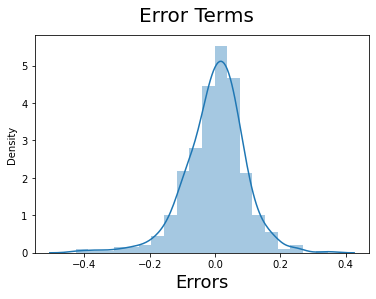

In [73]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### The residuals are following the normally distributed with a mean 0. All good!

## Looking for patterns in the residuals

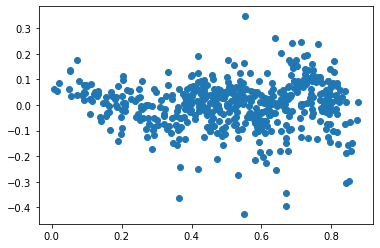

In [74]:
plt.scatter(y_train_cnt,(y_train - y_train_cnt))
plt.show()

From above plot we can see that residuals (also known as error terms) are independent. This means that there is no correlation between the residuals and the predicted values, or among the residuals themselves.

### We are confident that the model fit isn't by chance, and has decent predictive power. The normality of residual terms allows some inference on the coefficients.

## Making Predictions

#### Applying the scaling on the test sets

In [75]:
# Apply scaler() to all the columns except the '0-1' and 'dummy' variables
num_vars = ["temp", "atemp", "hum", "windspeed", "cnt"]

bike_df_test[num_vars] = scaler.transform(bike_df_test[num_vars])

In [76]:
bike_df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


#### Dividing into X_test and y_test

In [77]:
y_test = bike_df_test.pop('cnt')
X_test = bike_df_test

In [78]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [79]:
# Making predictions
y_pred = lm_7.predict(X_test_new)

## Model Evaluation

Text(0, 0.5, 'y_pred')

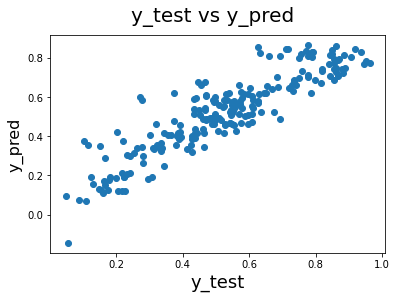

In [80]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

## Looking at the RMSE

In [81]:
#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(y_test, y_pred))

0.09576593186119745

In [82]:
R2 = r2_score(y_test, y_pred)
R2

0.8069068816299572

In [83]:
adj_R2 = 1-(1-R2)*(219-1)/(219-12-1)
adj_R2

0.7956587388122848

## So final r2_score (R-Squared) for test set is 0.8069068816299572.
## And Adjusted R-Squared value for test set is 0.7956587388122848

In [84]:
print(lm_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     205.1
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          1.04e-183
Time:                        19:21:56   Log-Likelihood:                 493.37
No. Observations:                 510   AIC:                            -960.7
Df Residuals:                     497   BIC:                            -905.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2059      0.028      7.423   


We can see that the equation of our best fitted line is:

$ cnt = 0.205947 + 0.234120 \times  yr + 0.021870  \times  workingday + 0.449452 \times temp - 0.148696 \times windspeed - 0.092775 \times spring + 0.077122 \times winter - 0.079888 \times weathersit_2 - 0.287815 \times weathersit_3 + 0.051687 \times month_3 + 0.042965 \times month_4 + 0.054176 \times month_5 + 0.079989 \times month_9 $


In [85]:
summary_df = pd.DataFrame({"Model Performance Metrics":["R-Squared Value","Adjusted R-Squared Value","RMSE"],
                         "Train Set":[0.832,0.828,0.09196],
                         "Test Set":[0.8069,0.7956,0.09576]})

# Conclusion

In [86]:
summary_df

,Model Performance Metrics,Train Set,Test Set
0,R-Squared Value,0.83200,0.80690
1,Adjusted R-Squared Value,0.82800,0.79560
2,RMSE,0.09196,0.09576


## Noteworthy Predictor Variables:

1. **yr**
2. **workingday**
3. **temp**
4. **windspeed**
5. **spring**
6. **winter**
7. **weathersit_2**
8. **weathersit_3**
9. **month_3**
10. **month_4**
11. **month_5**
12. **month_9**

These statistically significant and impactful predictor variables should be a focal point for the company when formulating its bike rental strategy. Consideration of these factors will likely contribute significantly to the accuracy and effectiveness of the strategy.